In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datatile.summary.df import DataFrameSummary
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import interpret
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings
warnings.filterwarnings("ignore")
from sklearn import svm
from sklearn.svm import LinearSVC

In [2]:
# read file
projectfilename = 'runups_distance.xlsx'

dfp = pd.read_excel(projectfilename)

# dealing with colums strategy, learn about data
# print(dfp.columns)
# print(dfp.shape)


In [3]:
dfsp = DataFrameSummary(dfp)

dfsp.summary()


,Year,Mo,Dy,Hr,Mn,Sec,Tsunami Event Validity,Tsunami Cause Code,Tsu Src,Earthquake Magnitude,...,Missing,Missing Description,Injuries,Injuries Description,Damage $Mil,Damage Description,Houses Destroyed,Houses Destroyed Description,Houses Damaged,Houses Damaged Description
count,25051.0,25049.0,25049.0,25020.0,25013.0,24592.0,25051.0,25051.0,25051.0,25051.0,...,49.0,49.0,99.0,107.0,101.0,1167.0,182.0,415.0,97.0,289.0
mean,1990.170931,6.13246,15.455467,9.836571,36.86483,26.085853,3.956808,1.163347,3568.576344,8.373199,...,85.632653,1.591837,106.030303,1.495327,3.616901,1.239075,160.576923,1.515663,179.515464,1.650519
std,28.150385,3.475828,8.563212,7.201232,16.60996,15.149356,0.325942,0.556564,1655.425043,0.793579,...,159.699287,1.059056,327.473148,0.805334,11.578974,0.594643,544.227094,0.824809,540.699877,2.463415
min,1900.0,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,1272.0,3.7,...,1.0,1.0,1.0,1.0,0.001,0.0,1.0,1.0,1.0,1.0
25%,1965.0,3.0,11.0,5.0,22.0,17.0,4.0,1.0,1982.0,7.8,...,2.0,1.0,2.0,1.0,0.02,1.0,4.0,1.0,4.0,1.0
50%,2004.0,5.0,13.0,6.0,46.0,24.1,4.0,1.0,2466.0,8.3,...,13.0,1.0,19.0,1.0,0.15,1.0,16.5,1.0,18.0,1.0
75%,2011.0,9.0,24.0,17.0,47.0,31.0,4.0,1.0,5413.0,9.1,...,71.0,2.0,68.0,2.0,1.0,1.0,59.5,2.0,100.0,2.0
max,2022.0,12.0,31.0,23.0,59.0,59.9,4.0,9.0,5828.0,9.5,...,717.0,4.0,2672.0,4.0,100.0,4.0,4615.0,4.0,3600.0,33.0
counts,25051,25049,25049,25020,25013,24592,25051,25051,25051,25051,...,49,49,99,107,101,1167,182,415,97,289
uniques,123,12,31,24,60,345,6,8,896,49,...,30,4,52,4,55,5,78,4,53,6


#### Discussion

From the summary table above, we observe there are many missing data.  We also observe that there is a range of tsunami validity code, and we have events ranging from "erroneous entry" to "definite tsunami".

As the aim of this project is to provide a wave height prediction for a given earthquake magnitude, we also observe that the wave height is measured differently for different events (i.e. "Measurement Type" varies).  This is based on available information, differing wave height recording standards, and the blend of observational evidence versus empirically measured data.

Initially we observed that we need to "flatten" the wave height column and perform the necessary conversions to a common standard for wave height.  We also observe that for several columns there is missing data, so we plan to determine correlated variables through a heatmap, then eliminate the unncessary columns before proceeding.

The wave height was converted for Measurement Types indicated as 2 or 3.  All other wave heights were considered approximately equal, and equal to the maximum wave amplitude.  From this a new feature column entitled "Adjusted Water Height (m)" is added.

Next, the rows in which the target variable was missing were eliminated.  Finally, the dataset considered only events that were designated as a "definite tsunami" were used.  

The total row deletion was 2183 rows out of 25051, or a little under 9%.

In [4]:
# handle measurement type: first view a sample for which the measurement type is 2 or 3.  Then, create a function to adjust
# the value in Maximum Water Height (m) by multiplying by 2 if the conditions are met, else return the same value.  Then create
# a new column entitled Adjusted Water Height (m) with the new values.

# print(dfp['Maximum Water Height (m)'].head(25))  # verify
# print(dfp['Measurement Type'].head(25))  # verify

def type_adj(row):
    if row['Measurement Type'] == 2:
        return row['Maximum Water Height (m)'] * 2
    elif row['Measurement Type'] == 3:
        return row['Maximum Water Height (m)'] * 2
    return row['Maximum Water Height (m)']

dfp['Adjusted Water Height (m)']=dfp.apply(lambda row: type_adj(row), axis=1)

# print(dfp['Maximum Water Height (m)'].head(25))  # verify
# print(dfp['Adjusted Water Height (m)'].head(25))  # verify
# print(dfp.columns)  # verify

In [5]:
# print(dfp.shape)  # returns (25051, 45)

# eliminate rows where target variable is missing
dfp = dfp.dropna(subset=['Maximum Water Height (m)'])

# print (dfp.shape)  # returns (23140, 45)
# print(dfp['Maximum Water Height (m)'].head(25))  # verify

# eliminate rows where Tsunami Event Validity \= 4 (definite tsunami)

# print(dfp['Tsunami Event Validity'])  # 3s in rows 2, 7, 8.  4s in rows 25050, 25049

dfp = dfp.drop(dfp[dfp['Tsunami Event Validity'] < 4].index)

# print(dfp['Tsunami Event Validity'])  # 3s in rows 2,7,8 are gone.  4s in rows 25050, 25049 are still there.

print(dfp.shape)  # returns (22868, 45)

# print(df2.isnull().sum())
# print(df2.shape)
# print(df2.head(10))

(22868, 45)


In [6]:
df = dfp.copy()  # copy dfp after macro adjustments
df = df.reset_index(drop=True)  # reset indices and drop new column of old indices

print(df.shape)  # verify
# print(df.head(5))  # verify
print(df.columns)  # verify

(22868, 45)
Index(['Year', 'Mo', 'Dy', 'Hr', 'Mn', 'Sec', 'Tsunami Event Validity',
       'Tsunami Cause Code', 'Tsu Src', 'Earthquake Magnitude', 'Vol',
       'More Info', 'Doubtful Runup', 'Country', 'Area', 'Location Name',
       'Latitude', 'Longitude', 'Distance From Source (km)',
       'Initial Wave Arrival Day', 'Initial Wave Arrival Hour',
       'Initial Wave Arrival Minute', 'Travel Hours', 'Travel Minutes',
       'Max Wave Arrival Day', 'Max Wave Arrival Hour',
       'Max Wave Arrival Minute', 'Maximum Water Height (m)',
       'Max Inundation Distance (m)', 'Measurement Type', 'Period',
       'First Motion', 'Deaths', 'Death Description', 'Missing',
       'Missing Description', 'Injuries', 'Injuries Description',
       'Damage $Mil', 'Damage Description', 'Houses Destroyed',
       'Houses Destroyed Description', 'Houses Damaged',
       'Houses Damaged Description', 'Adjusted Water Height (m)'],
      dtype='object')


In [7]:
# summary snapshot

dfs = DataFrameSummary(df)

dfs.summary()

,Year,Mo,Dy,Hr,Mn,Sec,Tsunami Event Validity,Tsunami Cause Code,Tsu Src,Earthquake Magnitude,...,Missing Description,Injuries,Injuries Description,Damage $Mil,Damage Description,Houses Destroyed,Houses Destroyed Description,Houses Damaged,Houses Damaged Description,Adjusted Water Height (m)
count,22868.0,22868.0,22868.0,22867.0,22860.0,22579.0,22868.0,22868.0,22868.0,22868.0,...,28.0,64.0,69.0,83.0,773.0,115.0,288.0,53.0,204.0,22868.0
mean,1992.554836,6.103857,15.447175,9.737482,37.473447,25.805572,4.0,1.154714,3656.795828,8.421152,...,1.857143,92.546875,1.492754,3.990639,1.288486,204.434783,1.569444,257.320755,1.803922,4.08015
std,25.982049,3.471594,8.511014,7.164598,16.377421,14.976913,0.0,0.536531,1645.263745,0.757722,...,1.208436,235.857701,0.778822,12.648999,0.650496,654.532391,0.856643,679.914355,2.885463,6.395118
min,1901.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,1279.0,3.7,...,1.0,1.0,1.0,0.001,1.0,1.0,1.0,1.0,1.0,0.0
25%,1969.0,3.0,11.0,5.0,23.0,17.0,4.0,1.0,2015.0,7.9,...,1.0,3.0,1.0,0.011,1.0,6.0,1.0,3.0,1.0,0.5
50%,2006.0,5.0,12.0,6.0,46.0,24.1,4.0,1.0,3016.0,8.4,...,1.0,14.5,1.0,0.11,1.0,30.0,1.0,18.0,1.0,2.18
75%,2011.0,9.0,25.0,17.0,48.0,29.0,4.0,1.0,5413.0,9.1,...,3.0,64.75,2.0,1.0,1.0,86.5,2.0,250.0,2.0,5.0
max,2022.0,12.0,31.0,23.0,59.0,59.9,4.0,6.0,5828.0,9.5,...,4.0,1625.0,4.0,100.0,4.0,4615.0,4.0,3600.0,33.0,524.26
counts,22868,22868,22868,22867,22860,22579,22868,22868,22868,22868,...,28,64,69,83,773,115,288,53,204,22868
uniques,112,12,31,24,60,305,1,4,589,45,...,3,37,4,48,4,64,4,36,6,2170


#### Discussion

We note that there is a substantial amount of missing data.  We now generate a heatmap to determine correlated variables and we reduce the feature set accordingly.

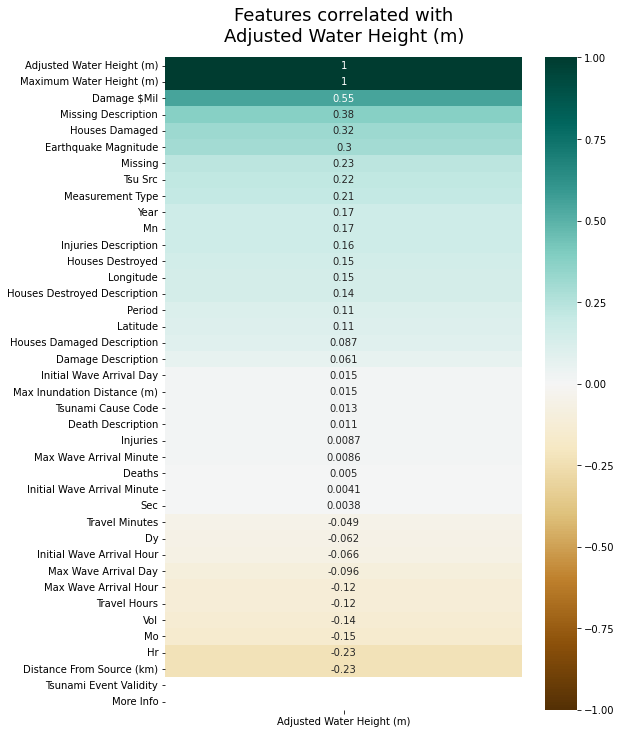

In [8]:
# generate a heatmap to visualize correlated features:

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Adjusted Water Height (m)']].sort_values(by='Adjusted Water Height (m)', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features correlated with\nAdjusted Water Height (m)', fontdict={'fontsize':18}, pad=16);


#### Discussion

The following columns may  be eliminated, as they are the result of a large tsunami and not a cause:<br>

- Deaths
- Death Description
- Missing
- Missing Description
- Injuries
- Injuries Description
- Damage $Mil
- Damage Description
- Houses Destroyed
- Houses Destroyed Description
- Houses Damaged
- Houses Damaged Description
- Max Inundation Distance (m)
- Measurement Type
- Doubtful Runup
- First Motion - though not a result, we do not consider this because we are focusing on maximum height and not which part of the wave it comes from.

We can also eliminate Maximum Water Height (m), as this is an intended duplicate feature of the target.<br>

Due to extreme missing data, we also eliminate the following features:<br>

- Max Wave Arrival Day
- Max Wave Arrival Hour
- Max Wave Arrival Minute
- Vol
- More Info
- Period
- Travel Hours
- Travel Minutes
- Initial Wave Arrival Hour
- Initial Wave Arrival Minute
- Initial Wave Arrival Day

We also drop the following text columns because we 'Latitude' and 'Longitude' is already numerical and accounted for in the data.<br>

- Country
- Area
- Location Name

We make the adjustments and determine the heatmap to use for analysis as described below.


In [9]:
df2 = df.copy()

# removal of temporal information helps preserve the data and prevents data leakage.  We therefore also remove time series 
# information.

df2 = df2.drop(['Deaths', 'Death Description', 'Missing', 'Missing Description', 'Injuries', 'Injuries Description', 
                'Damage $Mil', 'Damage Description', 'Houses Destroyed', 'Houses Destroyed Description', 'Houses Damaged', 
                'Houses Damaged Description', 'Max Inundation Distance (m)', 'Measurement Type', 'Doubtful Runup', 
                'First Motion', 'Maximum Water Height (m)', 'Max Wave Arrival Day', 'Max Wave Arrival Hour', 
                'Max Wave Arrival Minute', 'Vol', 'More Info', 'Country', 'Area', 'Location Name', 'Period', 'Travel Hours', 
                'Travel Minutes', 'Initial Wave Arrival Hour', 'Initial Wave Arrival Minute', 
                'Initial Wave Arrival Day',
               'Year', 'Mn', 'Sec', 'Dy', 'Mo', 'Hr', 'Tsunami Cause Code', 'Tsunami Event Validity'], axis=1)



# print(df2.head(10))  # verify
print(df2.shape)

(22868, 6)


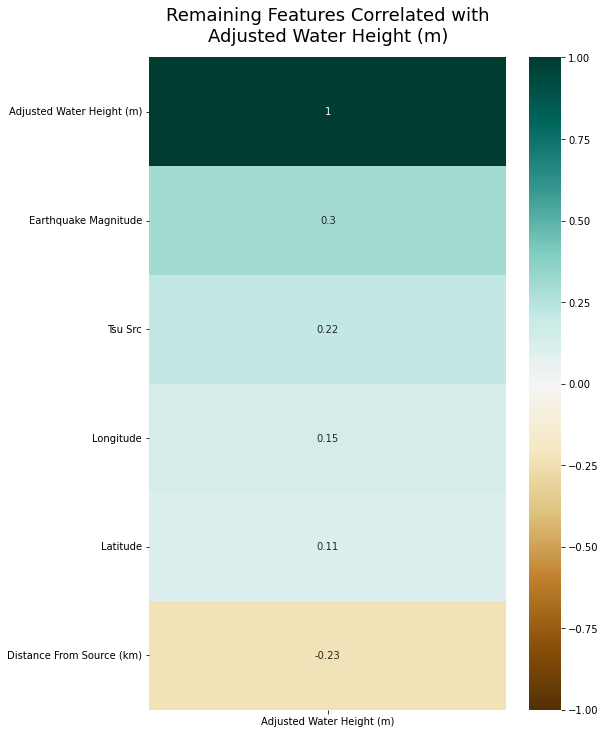

In [10]:
# we re-run the heatmap to show the result and begin feature selection

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df2.corr()[['Adjusted Water Height (m)']].sort_values(by='Adjusted Water Height (m)', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Remaining Features Correlated with\nAdjusted Water Height (m)', fontdict={'fontsize':18}, pad=16);

#### Discussion

Based on the above heatmap, we observe that the features most highly correlated to Adjusted Water Height (m) are:<br>

- Earthquake Magnitude (positive correlation)<br>
- Tsu Src (positive correlation)<br>
- Longitude (positive correlation)<br>
- Latitude (positive correlation)<br>
- Distance from Source (km) (negative correlation)<br>

Intuitively, this result makes sense.  The larger the earthquake, the larger the expected wave height.  "Tsu Src" (Tsunami Source) also makes sense because one may expect that an earthquake closer to a runup location would have a larger impact than an earthquake far away from a runup location.  We therefore are not surprised to see Latitude and Longitude.<br>

In [11]:
# Scale data:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# scaler = MinMaxScaler()
# df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

# scaler = StandardScaler()
# df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

scaler = RobustScaler()
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

dfs = DataFrameSummary(df2)

dfs.summary()


,Tsu Src,Earthquake Magnitude,Latitude,Longitude,Distance From Source (km),Adjusted Water Height (m)
count,22868.0,22868.0,22868.0,22868.0,22868.0,22868.0
mean,0.18858,0.017627,-0.353044,-0.391493,0.665111,0.422255
std,0.484186,0.631435,0.657488,0.568153,1.2477,1.421137
min,-0.511183,-3.916667,-2.83393,-1.469129,-0.073962,-0.484444
25%,-0.294585,-0.416667,-0.880885,-0.967522,-0.038565,-0.373333
50%,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.705415,0.583333,0.119115,0.032478,0.961435,0.626667
max,0.827546,0.916667,0.763107,0.208976,5.53665,116.017778
counts,22868,22868,22868,22868,22868,22868
uniques,589,45,13386,13388,21332,2170


In [12]:
# remove duplicate rows:
df2 = df2.drop_duplicates()
df2 = df2.reset_index(drop=True)  # reset indices and drop new column of old indices
print(df2.shape)


(22673, 6)


In [13]:
# impute any missing values (showing none so this is not necessary)
from sklearn.impute import SimpleImputer

imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # create imputer
df2.iloc[0:,1:]=imputer.fit_transform(df2.iloc[0:,1:])  # fit imputer

In [14]:
# ver1 = df2.to_csv('ver1.csv', encoding='utf-8')  # verification copy

dfs = DataFrameSummary(df2)

dfs.summary()

,Tsu Src,Earthquake Magnitude,Latitude,Longitude,Distance From Source (km),Adjusted Water Height (m)
count,22673.0,22673.0,22673.0,22673.0,22673.0,22673.0
mean,0.191427,0.017672,-0.353663,-0.39143,0.665695,0.42115
std,0.484325,0.632343,0.658767,0.567892,1.248869,1.420914
min,-0.511183,-3.916667,-2.83393,-1.469129,-0.073962,-0.484444
25%,-0.292819,-0.416667,-0.883485,-0.967519,-0.038541,-0.373333
50%,0.0,0.0,0.000834,0.000079,0.0,-0.004444
75%,0.705415,0.583333,0.119163,0.032478,0.959842,0.626667
max,0.827546,0.916667,0.763107,0.208976,5.53665,116.017778
counts,22673,22673,22673,22673,22673,22673
uniques,589,45,13386,13388,21332,2170


In [15]:
dffull=df2.copy()
print(dffull.shape)

# print(dffull.columns)
# # print(dffull.head(5))
# print(dffull.shape)
# print(df2.shape)

# ver2 = dffull.to_csv('ver2.csv', encoding='utf-8')  # verification copy

dfs = DataFrameSummary(dffull)

dfs.summary()

(22673, 6)


,Tsu Src,Earthquake Magnitude,Latitude,Longitude,Distance From Source (km),Adjusted Water Height (m)
count,22673.0,22673.0,22673.0,22673.0,22673.0,22673.0
mean,0.191427,0.017672,-0.353663,-0.39143,0.665695,0.42115
std,0.484325,0.632343,0.658767,0.567892,1.248869,1.420914
min,-0.511183,-3.916667,-2.83393,-1.469129,-0.073962,-0.484444
25%,-0.292819,-0.416667,-0.883485,-0.967519,-0.038541,-0.373333
50%,0.0,0.0,0.000834,0.000079,0.0,-0.004444
75%,0.705415,0.583333,0.119163,0.032478,0.959842,0.626667
max,0.827546,0.916667,0.763107,0.208976,5.53665,116.017778
counts,22673,22673,22673,22673,22673,22673
uniques,589,45,13386,13388,21332,2170


In [16]:
df2_feat=dffull.drop(['Adjusted Water Height (m)'], axis=1)

# print(df2_feat.columns)
# print(df2_feat.head(5))
print(df2_feat.shape)

target = dffull['Adjusted Water Height (m)']

# print(target)

(22673, 5)


In [17]:
# check for missing values and scaling opportunities:

dfs2 = DataFrameSummary(df2_feat)
dfs2.summary()

,Tsu Src,Earthquake Magnitude,Latitude,Longitude,Distance From Source (km)
count,22673.0,22673.0,22673.0,22673.0,22673.0
mean,0.191427,0.017672,-0.353663,-0.39143,0.665695
std,0.484325,0.632343,0.658767,0.567892,1.248869
min,-0.511183,-3.916667,-2.83393,-1.469129,-0.073962
25%,-0.292819,-0.416667,-0.883485,-0.967519,-0.038541
50%,0.0,0.0,0.000834,0.000079,0.0
75%,0.705415,0.583333,0.119163,0.032478,0.959842
max,0.827546,0.916667,0.763107,0.208976,5.53665
counts,22673,22673,22673,22673,22673
uniques,589,45,13386,13388,21332


In [18]:
# reset figure size for figures
plt.rcParams["figure.figsize"] = (10, 6)

In [19]:
# split data

X_train, X_test, y_train, y_test = train_test_split(df2_feat, target, test_size=0.30)

In [20]:
# train several models and predict

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR

# linear regression
linreg = LinearRegression().fit(X_train, y_train)
LRpred = linreg.predict(X_test)

# bayesian ridge 
br = linear_model.BayesianRidge().fit(X_train, y_train)
brpred = br.predict(X_test)

# lasso
lo = LassoCV(cv=5, random_state=1).fit(X_train, y_train)
lopred = lo.predict(X_test)

# ElasticNet
el = ElasticNetCV(cv=5, random_state=1).fit(X_train, y_train)
elpred = el.predict(X_test)

# epsilon-support vector regression
svrA = SVR(kernel='rbf', C=1, epsilon=10).fit(X_train, y_train)
svrApred = svrA.predict(X_test)

# epsilon-support vector regression
svrB = SVR(kernel='poly', degree=5, C=2, epsilon=0.5).fit(X_train, y_train)  # -3.16, -5.66, C = 1, epsilon=1
svrBpred = svrB.predict(X_test)


In [21]:
# MAE, RMSE for regression models:

lrMAE = cross_val_score(linreg, df2_feat, target, cv=10, scoring='neg_mean_absolute_error')
lrRMSE = cross_val_score(linreg, df2_feat, target, cv=10, scoring='neg_root_mean_squared_error')
print("MAE for Linear Regression (mean): %0.4f" % lrMAE.mean())
print("RMSE for Linear Regression (mean): %0.4f" % lrRMSE.mean())

brMAE = cross_val_score(br, df2_feat, target, cv=10, scoring='neg_mean_absolute_error')
brRMSE = cross_val_score(br, df2_feat, target, cv=10, scoring='neg_root_mean_squared_error')
print("MAE for Bayesian Ridge (mean): %0.4f" % brMAE.mean())
print("RMSE for Bayesian Ridge (mean): %0.4f" % brRMSE.mean())

loMAE = cross_val_score(lo, df2_feat, target, cv=10, scoring='neg_mean_absolute_error')
loRMSE = cross_val_score(lo, df2_feat, target, cv=10, scoring='neg_root_mean_squared_error')
print("MAE for LassoCV (mean): %0.4f" % loMAE.mean())
print("RMSE for LassoCV (mean): %0.4f" % loRMSE.mean())

elMAE = cross_val_score(el, df2_feat, target, cv=10, scoring='neg_mean_absolute_error')
elRMSE = cross_val_score(el, df2_feat, target, cv=10, scoring='neg_root_mean_squared_error')
print("MAE for ElasticNetCV (mean): %0.4f" % elMAE.mean())
print("RMSE for ElasticNetCV (mean): %0.4f" % elRMSE.mean())

svrAMAE = cross_val_score(svrA, df2_feat, target, cv=10, scoring='neg_mean_absolute_error')
svrARMSE = cross_val_score(svrA, df2_feat, target, cv=10, scoring='neg_root_mean_squared_error')
print("MAE for SVR A (rfb, default) (mean): %0.4f" % svrAMAE.mean())  # -7.34
print("RMSE for SVR A (rfb, default) (mean): %0.4f" % svrARMSE.mean())  # -8.41

svrBMAE = cross_val_score(svrB, df2_feat, target, cv=10, scoring='neg_mean_absolute_error')
svrBRMSE = cross_val_score(svrB, df2_feat, target, cv=10, scoring='neg_root_mean_squared_error')
print("MAE for SVR B (5th deg poly) (mean): %0.4f" % svrBMAE.mean())
print("RMSE for SVR B (5th deg poly) (mean): %0.4f" % svrBRMSE.mean())

MAE for Linear Regression (mean): -0.6988
RMSE for Linear Regression (mean): -1.1578
MAE for Bayesian Ridge (mean): -0.6988
RMSE for Bayesian Ridge (mean): -1.1578
MAE for LassoCV (mean): -0.6991
RMSE for LassoCV (mean): -1.1583
MAE for ElasticNetCV (mean): -0.6989
RMSE for ElasticNetCV (mean): -1.1581
MAE for SVR A (rfb, default) (mean): -8.7176
RMSE for SVR A (rfb, default) (mean): -8.8227
MAE for SVR B (5th deg poly) (mean): -0.7586
RMSE for SVR B (5th deg poly) (mean): -1.3212


In [22]:
# Visualize correlations

import interpret
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

eXBM = ExplainableBoostingClassifier()
eXBMpredict = eXBM.fit(X_train, y_train)
eXBM_global = eXBM.explain_global()
show(eXBM_global)

<!-- http://127.0.0.1:7001/1616681966656/ -->

#### Discussion

Using InterpretML to show the relationship between Distance from Source, Earthquake Magnitude, and Adjusted Wave Height, we observed that the largest contributor to our prediction is Distance from Source, as expected.  We break this down by visualizing a distribution of distances for further evaluation.

Additionally, the greater the earthquake magnitude, the greater the height, as expected.  We looked to refine our analysis further by grouping the data into segments based on earthquake magnitude to help provide more granular information to affected populations.  Based on the image below, we selected the following groupings from our data:

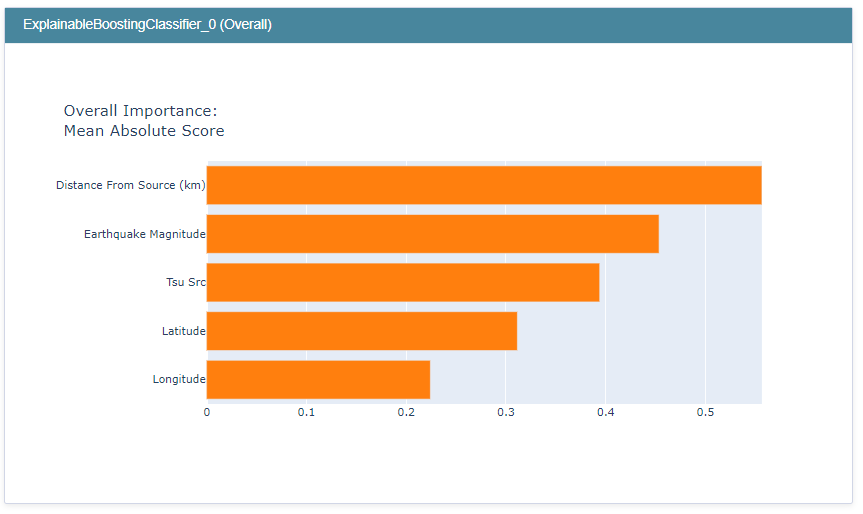

In [23]:
# # Data validation step

# # full df: 'dffull'
# # print(dffull.head(145))

# df_full=dffull.to_csv('dffull.csv', encoding='utf-8')  # for testing, to verify dataframe looks the way we think it should look.
# tested_data = X_test
# tested_y = y_test

# predicted_y = pd.DataFrame(LRpred, columns=['Predictions']).to_csv('predicted_y_LR.csv')
# td = tested_data.to_csv('X_test.csv', encoding='utf-8')
# ty = tested_y.to_csv('y_test.csv', encoding='utf-8')

# df_full
# td
# ty

In [24]:
# print(df2_feat[df2_feat['Distance From Source (km)']==df2_feat['Distance From Source (km)'].min()])  # returns 2: -0.074
# print(df2_feat[df2_feat['Distance From Source (km)']==df2_feat['Distance From Source (km)'].max()])  # returns 1: 5.546

# 11332 data are greater than 300

# iterate
columncount = df2_feat['Distance From Source (km)']
count = columncount[columncount > 0.0004].count()
count

11239

In [25]:
# print(df2_feat[df2_feat['Earthquake Magnitude']==df2_feat['Earthquake Magnitude'].min()])  # returns 2: -3.916
# print(df2_feat[df2_feat['Earthquake Magnitude']==df2_feat['Earthquake Magnitude'].max()])  # returns 1: 0.916

# < 8 (6888 data with magnitude less than 8.0) - due to scaling, this is approximate: -0.251
# 8 - 9 (7954 are between 8 and 9) - due to scaling, this is approximate: -0.251 and 0.5
# 9+  0.5ish rest: (9637 are gt 9) - due to scaling, this is approximate: > 0.5

# df_8to9 = dffull.loc[(dffull['Earthquake Magnitude'] > 8.0) & (dffull['Earthquake Magnitude'] < 9.0)]

# iterate
columncount = df2_feat['Earthquake Magnitude']
count = columncount[columncount > 0.5].count()
count

9162

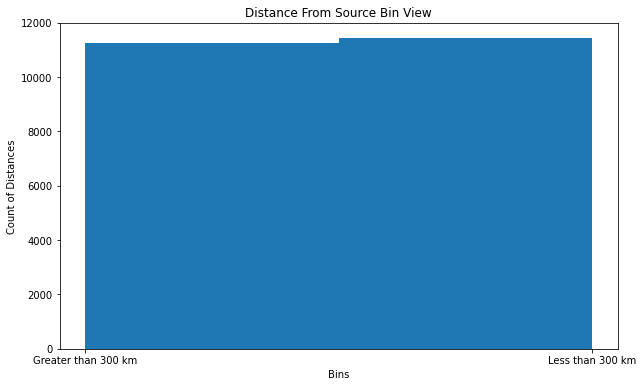

In [26]:
dist_bins = [-0.074, 0.0004, 5.546]
# dist_labels = ['Less than 8.0', 'Greater than 8.0, Less than 9.0', 'Greater than 9.0']
dist_labels = ['Less than 300 km', 'Greater than 300 km']
df2_feat['Dist_Bins']=pd.cut(df2_feat['Distance From Source (km)'], bins=dist_bins, labels=dist_labels, include_lowest=True)
# df2_feat['Dist_Bins']=pd.cut(df2_feat['Distance From Source (km)'], bins=dist_bins)
plt.hist(df2_feat['Dist_Bins'], bins=2)
plt.title("Distance From Source Bin View")
plt.xlabel('Bins')
plt.ylabel('Count of Distances')  # seems correlated
plt.show()

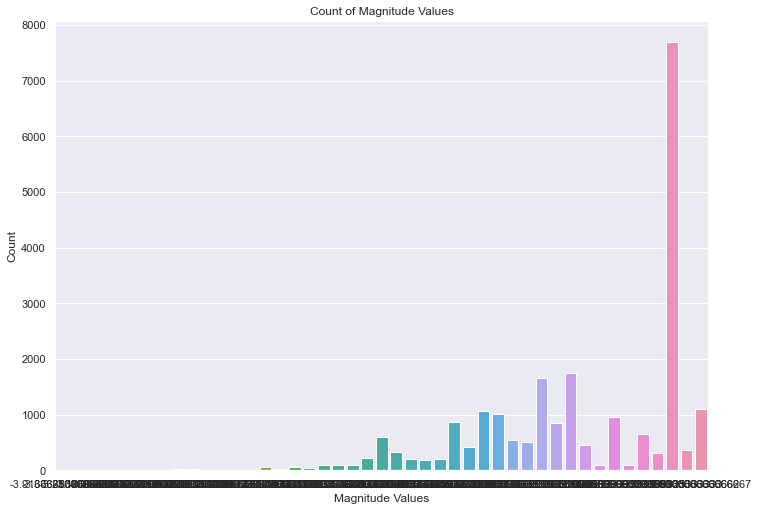

In [27]:
sns.set(style="whitegrid", color_codes=True)  # set background to white
sns.set(rc={'figure.figsize':(11.7,8.27)})  # set plot size for all plots
# sns.countplot(x='Earthquake Magnitude', data=df2_feat, hue='No-show')  # create a countplot
sns.countplot(x='Earthquake Magnitude', data=df2_feat)  # create a countplot
plt.title('Count of Magnitude Values')
plt.xlabel('Magnitude Values')
plt.ylabel('Count')
plt.show()

#### Discussion

Initial analysis shows that there are a large amount of data points below 300 km, and several distances are counted many times.  We therefore select 300 km as a cutoff for the data, and observe that the balance is nearly equal between the two groups.  We therefore create new dataframes for the following groups to subject to additional analysis:<br>

- Distance from Source < 300<br>
- Distance from Source >= 300<br>

Given that the number of high-magnitude earthquakes from the event data is overwhelmingly favoring the upper end of the spectrum, we decided to group the events to try to improve performance.  We determine three bins:<br>

- Magnitude < 8.0<br>
- Magnitude > 8.0 and < 9.0<br>
- Magnitude > 9.0<br>

In [28]:
# print(df2_feat[df2_feat['Distance From Source (km)']==df2_feat['Distance From Source (km)'].min()])  # returns 2: 0
# print(df2_feat[df2_feat['Distance From Source (km)']==df2_feat['Distance From Source (km)'].max()])  # returns 1: 19277.528

# columncount = df2_feat['Distance From Source (km)']
# count = columncount[columncount > 300].count()
# count

# > 300 - 10365 values
# > 5000 - 4298 values
# > 8000 - 2755 values
# > 10000 - 2013 values
# > 15000 - 854 values

df_lt300 = dffull.loc[(dffull['Distance From Source (km)'] < 0.0004)]
print(df_lt300.shape)

df_gt300 = dffull.loc[(dffull['Distance From Source (km)'] >= 0.0004)]
print(df_gt300.shape)

# Analyzing the df_0to8 group:
df_lt300_feat=df_lt300.drop(['Adjusted Water Height (m)'], axis=1)
print(df_lt300_feat.shape)

target_lt300 = df_lt300['Adjusted Water Height (m)']
print(target_lt300)

dfslt300 = DataFrameSummary(df_lt300_feat)
dfslt300.summary()

(11434, 6)
(11239, 6)
(11434, 5)
2       -0.217778
26      -0.440000
27      -0.151111
32       1.737778
33       2.848889
           ...   
22666   -0.475556
22669   -0.271111
22670   -0.453333
22671   -0.453333
22672   -0.440000
Name: Adjusted Water Height (m), Length: 11434, dtype: float64


,Tsu Src,Earthquake Magnitude,Latitude,Longitude,Distance From Source (km)
count,11434.0,11434.0,11434.0,11434.0,11434.0
mean,0.358404,-0.042665,-0.350436,-0.243751,-0.036795
std,0.459421,0.652407,0.676969,0.461734,0.017749
min,-0.510594,-3.916667,-2.466791,-1.469129,-0.073962
25%,-0.181872,-0.5,-0.941475,-0.476108,-0.048699
50%,0.705415,-0.083333,0.092672,0.02952,-0.038331
75%,0.705415,0.583333,0.119558,0.033259,-0.021185
max,0.827546,0.916667,0.67797,0.208976,0.000397
counts,11434,11434,11434,11434,11434
uniques,469,44,9281,9230,10464


In [29]:
X_train_lt300, X_test_lt300, y_train_lt300, y_test_lt300 = train_test_split(df_lt300_feat, target_lt300, test_size=0.30)

In [30]:
# train several models and predict

# linear regression
linreg_lt300 = LinearRegression().fit(X_train_lt300, y_train_lt300)
LRpred_lt300 = linreg_lt300.predict(X_test_lt300)

# bayesian ridge 
br_lt300 = linear_model.BayesianRidge().fit(X_train_lt300, y_train_lt300)
brpred_lt300 = br_lt300.predict(X_test_lt300)

# lasso
lo_lt300 = LassoCV(cv=5, random_state=1).fit(X_train_lt300, y_train_lt300)
lopred_lt300 = lo_lt300.predict(X_test_lt300)

# ElasticNet
el_lt300 = ElasticNetCV(cv=5, random_state=1).fit(X_train_lt300, y_train_lt300)
elpred_lt300 = el_lt300.predict(X_test_lt300)

# epsilon-support vector regression
svrA_lt300 = SVR(kernel='rbf', C=1, epsilon=10).fit(X_train_lt300, y_train_lt300)
svrApred_lt300 = svrA_lt300.predict(X_test_lt300)

# epsilon-support vector regression
svrB_lt300 = SVR(kernel='poly', degree=5, C=2, epsilon=0.5).fit(X_train_lt300, y_train_lt300)
svrBpred_lt300 = svrB_lt300.predict(X_test_lt300)

In [31]:
# MAE, RMSE for regression models:

lrMAE_lt300 = cross_val_score(linreg_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_mean_absolute_error')
lrRMSE_lt300 = cross_val_score(linreg_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_lt300 for Linear Regression (mean): %0.2f" % lrMAE_lt300.mean())
print("RMSE_lt300 for Linear Regression (mean): %0.2f" % lrRMSE_lt300.mean())

brMAE_lt300 = cross_val_score(br_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_mean_absolute_error')
brRMSE_lt300 = cross_val_score(br_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_lt300 for Bayesian Ridge (mean): %0.2f" % brMAE_lt300.mean())
print("RMSE_lt300 for Bayesian Ridge (mean): %0.2f" % brRMSE_lt300.mean())

loMAE_lt300 = cross_val_score(lo_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_mean_absolute_error')
loRMSE_lt300 = cross_val_score(lo_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_lt300 for LassoCV (mean): %0.2f" % loMAE_lt300.mean())
print("RMSE_lt300 for LassoCV (mean): %0.2f" % loRMSE_lt300.mean())

elMAE_lt300 = cross_val_score(el_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_mean_absolute_error')
elRMSE_lt300 = cross_val_score(el_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_lt300 for ElasticNetCV (mean): %0.2f" % elMAE_lt300.mean())
print("RMSE_lt300 for ElasticNetCV (mean): %0.2f" % elRMSE_lt300.mean())

svrAMAE_lt300 = cross_val_score(svrA_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_mean_absolute_error')
svrARMSE_lt300 = cross_val_score(svrA_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_lt300 for SVR A (rfb, default) (mean): %0.2f" % svrAMAE_lt300.mean())  # -7.34
print("RMSE_lt300 for SVR A (rfb, default) (mean): %0.2f" % svrARMSE_lt300.mean())  # -8.41

svrBMAE_lt300 = cross_val_score(svrB_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_mean_absolute_error')
svrBRMSE_lt300 = cross_val_score(svrB_lt300, df_lt300_feat, target_lt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_lt300 for SVR B (5th degree polynomial) (mean): %0.2f" % svrBMAE_lt300.mean())
print("RMSE_lt300 for SVR B (5th degree polynomial) (mean): %0.2f" % svrBRMSE_lt300.mean())

MAE_lt300 for Linear Regression (mean): -0.91
RMSE_lt300 for Linear Regression (mean): -1.47
MAE_lt300 for Bayesian Ridge (mean): -0.90
RMSE_lt300 for Bayesian Ridge (mean): -1.47
MAE_lt300 for LassoCV (mean): -0.90
RMSE_lt300 for LassoCV (mean): -1.46
MAE_lt300 for ElasticNetCV (mean): -0.90
RMSE_lt300 for ElasticNetCV (mean): -1.46
MAE_lt300 for SVR A (rfb, default) (mean): -8.39
RMSE_lt300 for SVR A (rfb, default) (mean): -8.55
MAE_lt300 for SVR B (5th degree polynomial) (mean): -0.96
RMSE_lt300 for SVR B (5th degree polynomial) (mean): -1.79


In [32]:
# df_gt300

df_gt300_feat=df_gt300.drop(['Adjusted Water Height (m)'], axis=1)
print(df_gt300_feat.shape)

target_gt300 = df_gt300['Adjusted Water Height (m)']
print(target_gt300)

dfsgt300 = DataFrameSummary(df_gt300_feat)
dfsgt300.summary()

(11239, 5)
0       -0.428889
1       -0.466667
3       -0.382222
4       -0.217778
5       -0.217778
           ...   
22663   -0.440000
22664   -0.395556
22665   -0.457778
22667   -0.462222
22668   -0.462222
Name: Adjusted Water Height (m), Length: 11239, dtype: float64


,Tsu Src,Earthquake Magnitude,Latitude,Longitude,Distance From Source (km)
count,11239.0,11239.0,11239.0,11239.0,11239.0
mean,0.021553,0.079055,-0.356947,-0.541671,1.380373
std,0.448637,0.605142,0.639731,0.62367,1.460588
min,-0.511183,-3.916667,-2.83393,-1.469129,0.000403
25%,-0.32784,-0.333333,-0.717979,-1.222253,0.113864
50%,-0.221601,0.166667,-0.182092,-0.246454,0.96471
75%,0.68452,0.583333,0.116238,0.029674,2.195114
max,0.820777,0.916667,0.763107,0.208976,5.53665
counts,11239,11239,11239,11239,11239
uniques,386,40,4705,4718,10868


In [33]:
X_train_gt300, X_test_gt300, y_train_gt300, y_test_gt300 = train_test_split(df_gt300_feat, target_gt300, test_size=0.30)

In [34]:
# train several models and predict

# linear regression
linreg_gt300 = LinearRegression().fit(X_train_gt300, y_train_gt300)
LRpred_gt300 = linreg_gt300.predict(X_test_gt300)

# bayesian ridge 
br_gt300 = linear_model.BayesianRidge().fit(X_train_gt300, y_train_gt300)
brpred_gt300 = br_gt300.predict(X_test_gt300)

# lasso
lo_gt300 = LassoCV(cv=5, random_state=1).fit(X_train_gt300, y_train_gt300)
lopred_gt300 = lo_gt300.predict(X_test_gt300)

# ElasticNet
el_gt300 = ElasticNetCV(cv=5, random_state=1).fit(X_train_gt300, y_train_gt300)
elpred_gt300 = el_gt300.predict(X_test_gt300)

# epsilon-support vector regression
svrA_gt300 = SVR(kernel='rbf', C=1, epsilon=10).fit(X_train_gt300, y_train_gt300)
svrApred_gt300 = svrA_gt300.predict(X_test_gt300)

# epsilon-support vector regression
svrB_gt300 = SVR(kernel='poly', degree=5, C=2, epsilon=0.5).fit(X_train_gt300, y_train_gt300)
svrBpred_gt300 = svrB_gt300.predict(X_test_gt300)

In [35]:
# MAE, RMSE for regression models:

lrMAE_gt300 = cross_val_score(linreg_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_mean_absolute_error')
lrRMSE_gt300 = cross_val_score(linreg_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt300 for Linear Regression (mean): %0.2f" % lrMAE_gt300.mean())
print("RMSE_gt300 for Linear Regression (mean): %0.2f" % lrRMSE_gt300.mean())

brMAE_gt300 = cross_val_score(br_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_mean_absolute_error')
brRMSE_gt300 = cross_val_score(br_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt300 for Bayesian Ridge (mean): %0.2f" % brMAE_gt300.mean())
print("RMSE_gt300 for Bayesian Ridge (mean): %0.2f" % brRMSE_gt300.mean())

loMAE_gt300 = cross_val_score(lo_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_mean_absolute_error')
loRMSE_gt300 = cross_val_score(lo_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt300 for LassoCV (mean): %0.2f" % loMAE_gt300.mean())
print("RMSE_gt300 for LassoCV (mean): %0.2f" % loRMSE_gt300.mean())

elMAE_gt300 = cross_val_score(el_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_mean_absolute_error')
elRMSE_gt300 = cross_val_score(el_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt300 for ElasticNetCV (mean): %0.2f" % elMAE_gt300.mean())
print("RMSE_gt300 for ElasticNetCV (mean): %0.2f" % elRMSE_gt300.mean())

svrAMAE_gt300 = cross_val_score(svrA_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_mean_absolute_error')
svrARMSE_gt300 = cross_val_score(svrA_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt300 for SVR A (rfb, default) (mean): %0.2f" % svrAMAE_gt300.mean())  # -7.34
print("RMSE_gt300 for SVR A (rfb, default) (mean): %0.2f" % svrARMSE_gt300.mean())  # -8.41

svrBMAE_gt300 = cross_val_score(svrB_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_mean_absolute_error')
svrBRMSE_gt300 = cross_val_score(svrB_gt300, df_gt300_feat, target_gt300, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt300 for SVR B (5th degree polynomial) (mean): %0.2f" % svrBMAE_gt300.mean())
print("RMSE_gt300 for SVR B (5th degree polynomial) (mean): %0.2f" % svrBRMSE_gt300.mean())

MAE_gt300 for Linear Regression (mean): -0.33
RMSE_gt300 for Linear Regression (mean): -0.48
MAE_gt300 for Bayesian Ridge (mean): -0.33
RMSE_gt300 for Bayesian Ridge (mean): -0.48
MAE_gt300 for LassoCV (mean): -0.33
RMSE_gt300 for LassoCV (mean): -0.48
MAE_gt300 for ElasticNetCV (mean): -0.33
RMSE_gt300 for ElasticNetCV (mean): -0.48
MAE_gt300 for SVR A (rfb, default) (mean): -3.05
RMSE_gt300 for SVR A (rfb, default) (mean): -3.09
MAE_gt300 for SVR B (5th degree polynomial) (mean): -0.40
RMSE_gt300 for SVR B (5th degree polynomial) (mean): -0.55


#### Discussion

Comparing the two groups, the models perform better when the distance from source is greater than 300 km.  Tsunami wave propagation effects are very complex and must be modeled carefully in order to understand the kinds of impacts created by subduction-type earthquakes in particular (these types of earthquakes do not propagate as point sources).  A combination of models can describe large-magnitude earthquakes as propagating outward and reaching a "dampened" state but will recover its full original magnitude by the time it reaches landfall.  Similarly, seafloor topology changes (especially those that are gradual) can limit dampening and allow a wave to propagate a near-full amplitude over a variety of ranges.  Obstacles such as islands, underwater mountains, and other wave reflectors contribute refractory effects from the wavefront that may add constructively or subtract destructively to overall wave amplitude as it makes landfall.

Generally, large-magnitude earthquakes that travel long distances have been shown to reach near-original amplitude again by the time they make landfall, which may allow our model to be in a sense "more accurate" at longer distances from source.  Though we observe this effect here, much more study of those specific events is required to fully understand wave propagation and how adjusted wave height of tsunamis at landfall locations are modelled.

Source: https://www.intechopen.com/chapters/41064

In [36]:
# df_0to8 = dffull.loc[(dffull['Earthquake Magnitude'] >= 0) & (dffull['Earthquake Magnitude'] <= 5.9)]
df_0to8 = dffull.loc[dffull['Earthquake Magnitude'] <= -0.251]

# verify
print(df_0to8.shape)  
# print(df_0to8.head(5))
# print(df_0to8[df_0to8['Earthquake Magnitude']==df_0to8['Earthquake Magnitude'].min()])
# print(df_0to8[df_0to8['Earthquake Magnitude']==df_0to8['Earthquake Magnitude'].max()])


# df_0to59 = dffull.loc[(dffull['Earthquake Magnitude'] >= 0) & (dffull['Earthquake Magnitude'] <= 5.9)]
df_8to9 = dffull.loc[(dffull['Earthquake Magnitude'] > -0.251) & (dffull['Earthquake Magnitude'] < 0.5)]

# verify
print(df_8to9.shape)  
# print(df_8to9.head(5))
# print(df_8to9[df_8to9['Earthquake Magnitude']==df_8to9['Earthquake Magnitude'].min()])
# print(df_8to9[df_8to9['Earthquake Magnitude']==df_8to9['Earthquake Magnitude'].max()])

# df_0to59 = dffull.loc[(dffull['Earthquake Magnitude'] >= 0) & (dffull['Earthquake Magnitude'] <= 5.9)]
df_gt9 = dffull.loc[dffull['Earthquake Magnitude'] > 0.5]

# verify
print(df_gt9.shape)  
# print(df_gt9.head(5))
# print(df_gt9[df_gt9['Earthquake Magnitude']==df_gt9['Earthquake Magnitude'].min()])
# print(df_gt9[df_gt9['Earthquake Magnitude']==df_gt9['Earthquake Magnitude'].max()])


(6679, 6)
(6528, 6)
(9162, 6)


#### Discussion

Our groupings are relatively close in size, so we proceed.

In [37]:
# Analyzing the df_0to8 group:
df_0to8_feat=df_0to8.drop(['Adjusted Water Height (m)'], axis=1)
print(df_0to8_feat.shape)

target_0to8 = df_0to8['Adjusted Water Height (m)']
print(target_0to8)

dfs3 = DataFrameSummary(df_0to8_feat)
dfs3.summary()

(6679, 5)
0       -0.428889
1       -0.466667
2       -0.217778
3       -0.382222
4       -0.217778
           ...   
22668   -0.462222
22669   -0.271111
22670   -0.453333
22671   -0.453333
22672   -0.440000
Name: Adjusted Water Height (m), Length: 6679, dtype: float64


,Tsu Src,Earthquake Magnitude,Latitude,Longitude,Distance From Source (km)
count,6679.0,6679.0,6679.0,6679.0,6679.0
mean,0.02981,-0.779433,-0.346405,-0.332197,0.393095
std,0.454005,0.38385,0.60549,0.520907,0.913391
min,-0.511183,-3.916667,-2.466791,-1.469129,-0.073962
25%,-0.281048,-1.083333,-0.92653,-0.620259,-0.053277
50%,-0.230135,-0.666667,-0.030323,-0.048675,-0.007897
75%,0.68452,-0.5,0.102125,0.02952,0.257732
max,0.827546,-0.333333,0.677844,0.208976,5.36022
counts,6679,6679,6679,6679,6679
uniques,532,33,2986,3044,6325


In [38]:
X_train_0to8, X_test_0to8, y_train_0to8, y_test_0to8 = train_test_split(df_0to8_feat, target_0to8, test_size=0.30)

In [39]:
# train several models and predict

# linear regression
linreg_0to8 = LinearRegression().fit(X_train_0to8, y_train_0to8)
LRpred_0to8 = linreg_0to8.predict(X_test_0to8)

# bayesian ridge 
br_0to8 = linear_model.BayesianRidge().fit(X_train_0to8, y_train_0to8)
brpred_0to8 = br_0to8.predict(X_test_0to8)

# lasso
lo_0to8 = LassoCV(cv=5, random_state=1).fit(X_train_0to8, y_train_0to8)
lopred_0to8 = lo_0to8.predict(X_test_0to8)

# ElasticNet
el_0to8 = ElasticNetCV(cv=5, random_state=1).fit(X_train_0to8, y_train_0to8)
elpred_0to8 = el_0to8.predict(X_test_0to8)

# epsilon-support vector regression
svrA_0to8 = SVR(kernel='rbf', C=1, epsilon=10).fit(X_train_0to8, y_train_0to8)
svrApred_0to8 = svrA_0to8.predict(X_test_0to8)

# epsilon-support vector regression
svrB_0to8 = SVR(kernel='poly', degree=5, C=2, epsilon=0.5).fit(X_train_0to8, y_train_0to8)
svrBpred_0to8 = svrB_0to8.predict(X_test_0to8)

In [40]:
# MAE, RMSE for regression models:

lrMAE_0to8 = cross_val_score(linreg_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_mean_absolute_error')
lrRMSE_0to8 = cross_val_score(linreg_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_0to8 for Linear Regression (mean): %0.2f" % lrMAE_0to8.mean())
print("RMSE_0to8 for Linear Regression (mean): %0.2f" % lrRMSE_0to8.mean())

brMAE_0to8 = cross_val_score(br_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_mean_absolute_error')
brRMSE_0to8 = cross_val_score(br_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_0to8 for Bayesian Ridge (mean): %0.2f" % brMAE_0to8.mean())
print("RMSE_0to8 for Bayesian Ridge (mean): %0.2f" % brRMSE_0to8.mean())

loMAE_0to8 = cross_val_score(lo_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_mean_absolute_error')
loRMSE_0to8 = cross_val_score(lo_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_0to8 for LassoCV (mean): %0.2f" % loMAE_0to8.mean())
print("RMSE_0to8 for LassoCV (mean): %0.2f" % loRMSE_0to8.mean())

elMAE_0to8 = cross_val_score(el_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_mean_absolute_error')
elRMSE_0to8 = cross_val_score(el_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_0to8 for ElasticNetCV (mean): %0.2f" % elMAE_0to8.mean())
print("RMSE_0to8 for ElasticNetCV (mean): %0.2f" % elRMSE_0to8.mean())

svrAMAE_0to8 = cross_val_score(svrA_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_mean_absolute_error')
svrARMSE_0to8 = cross_val_score(svrA_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_0to8 for SVR A (rfb, default) (mean): %0.2f" % svrAMAE_0to8.mean())  # -7.34
print("RMSE_0to8 for SVR A (rfb, default) (mean): %0.2f" % svrARMSE_0to8.mean())  # -8.41

svrBMAE_0to8 = cross_val_score(svrB_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_mean_absolute_error')
svrBRMSE_0to8 = cross_val_score(svrB_0to8, df_0to8_feat, target_0to8, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_0to8 for SVR B (5th degree polynomial) (mean): %0.2f" % svrBMAE_0to8.mean())
print("RMSE_0to8 for SVR B (5th degree polynomial) (mean): %0.2f" % svrBRMSE_0to8.mean())

MAE_0to8 for Linear Regression (mean): -0.37
RMSE_0to8 for Linear Regression (mean): -0.94
MAE_0to8 for Bayesian Ridge (mean): -0.37
RMSE_0to8 for Bayesian Ridge (mean): -0.94
MAE_0to8 for LassoCV (mean): -0.36
RMSE_0to8 for LassoCV (mean): -0.94
MAE_0to8 for ElasticNetCV (mean): -0.36
RMSE_0to8 for ElasticNetCV (mean): -0.94
MAE_0to8 for SVR A (rfb, default) (mean): -9.20
RMSE_0to8 for SVR A (rfb, default) (mean): -9.35
MAE_0to8 for SVR B (5th degree polynomial) (mean): -0.44
RMSE_0to8 for SVR B (5th degree polynomial) (mean): -0.99


In [41]:
# Analyzing the df_8to9 group:
df_8to9_feat=df_8to9.drop(['Adjusted Water Height (m)'], axis=1)
print(df_8to9_feat.shape)

target_8to9 = df_8to9['Adjusted Water Height (m)']
print(target_8to9)

dfs4 = DataFrameSummary(df_8to9_feat)
dfs4.summary()

(6528, 5)
11      -0.404444
12      -0.422222
13      -0.408889
14      -0.462222
15      -0.360000
           ...   
22661   -0.466667
22662   -0.351111
22663   -0.440000
22664   -0.395556
22665   -0.457778
Name: Adjusted Water Height (m), Length: 6528, dtype: float64


,Tsu Src,Earthquake Magnitude,Latitude,Longitude,Distance From Source (km)
count,6528.0,6528.0,6528.0,6528.0,6528.0
mean,0.10737,-0.044373,-0.650598,-0.698026,0.707529
std,0.467007,0.188824,0.786074,0.613772,1.150756
min,-0.49588,-0.25,-2.83393,-1.469129,-0.07358
25%,-0.33814,-0.25,-1.451005,-1.28328,-0.022998
50%,0.0,-0.083333,-0.364077,-0.96227,0.008545
75%,0.490288,0.166667,0.101076,0.029987,1.021392
max,0.819894,0.333333,0.677844,0.208976,5.379478
counts,6528,6528,6528,6528,6528
uniques,52,8,3839,3873,6115


In [42]:
X_train_8to9, X_test_8to9, y_train_8to9, y_test_8to9 = train_test_split(df_8to9_feat, target_8to9, test_size=0.30)

In [43]:
# train several models and predict

# linear regression
linreg_8to9 = LinearRegression().fit(X_train_8to9, y_train_8to9)
LRpred_8to9 = linreg_8to9.predict(X_test_8to9)

# bayesian ridge 
br_8to9 = linear_model.BayesianRidge().fit(X_train_8to9, y_train_8to9)
brpred_8to9 = br_8to9.predict(X_test_8to9)

# lasso
lo_8to9 = LassoCV(cv=5, random_state=1).fit(X_train_8to9, y_train_8to9)
lopred_8to9 = lo_8to9.predict(X_test_8to9)

# ElasticNet
el_8to9 = ElasticNetCV(cv=5, random_state=1).fit(X_train_8to9, y_train_8to9)
elpred_8to9 = el_8to9.predict(X_test_8to9)

# epsilon-support vector regression
svrA_8to9 = SVR(kernel='rbf', C=1, epsilon=10).fit(X_train_8to9, y_train_8to9)
svrApred_8to9 = svrA_8to9.predict(X_test_8to9)

# epsilon-support vector regression
svrB_8to9 = SVR(kernel='poly', degree=5, C=2, epsilon=0.5).fit(X_train_8to9, y_train_8to9)
svrBpred_8to9 = svrB_8to9.predict(X_test_8to9)

In [44]:
# MAE, RMSE for regression models:

lrMAE_8to9 = cross_val_score(linreg_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_mean_absolute_error')
lrRMSE_8to9 = cross_val_score(linreg_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_8to9 for Linear Regression (mean): %0.2f" % lrMAE_8to9.mean())
print("RMSE_8to9 for Linear Regression (mean): %0.2f" % lrRMSE_8to9.mean())

brMAE_8to9 = cross_val_score(br_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_mean_absolute_error')
brRMSE_8to9 = cross_val_score(br_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_8to9 for Bayesian Ridge (mean): %0.2f" % brMAE_8to9.mean())
print("RMSE_8to9 for Bayesian Ridge (mean): %0.2f" % brRMSE_8to9.mean())

loMAE_8to9 = cross_val_score(lo_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_mean_absolute_error')
loRMSE_8to9 = cross_val_score(lo_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_8to9 for LassoCV (mean): %0.2f" % loMAE_8to9.mean())
print("RMSE_8to9 for LassoCV (mean): %0.2f" % loRMSE_8to9.mean())

elMAE_8to9 = cross_val_score(el_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_mean_absolute_error')
elRMSE_8to9 = cross_val_score(el_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_8to9 for ElasticNetCV (mean): %0.2f" % elMAE_8to9.mean())
print("RMSE_8to9 for ElasticNetCV (mean): %0.2f" % elRMSE_8to9.mean())

svrAMAE_8to9 = cross_val_score(svrA_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_mean_absolute_error')
svrARMSE_8to9 = cross_val_score(svrA_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_8to9 for SVR A (rfb, default) (mean): %0.2f" % svrAMAE_8to9.mean())  # -7.34
print("RMSE_8to9 for SVR A (rfb, default) (mean): %0.2f" % svrARMSE_8to9.mean())  # -8.41

svrBMAE_8to9 = cross_val_score(svrB_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_mean_absolute_error')
svrBRMSE_8to9 = cross_val_score(svrB_8to9, df_8to9_feat, target_8to9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_8to9 for SVR B (5th degree polynomial) (mean): %0.2f" % svrBMAE_8to9.mean())
print("RMSE_8to9 for SVR B (5th degree polynomial) (mean): %0.2f" % svrBRMSE_8to9.mean())

MAE_8to9 for Linear Regression (mean): -0.49
RMSE_8to9 for Linear Regression (mean): -0.71
MAE_8to9 for Bayesian Ridge (mean): -0.49
RMSE_8to9 for Bayesian Ridge (mean): -0.71
MAE_8to9 for LassoCV (mean): -0.51
RMSE_8to9 for LassoCV (mean): -0.74
MAE_8to9 for ElasticNetCV (mean): -0.51
RMSE_8to9 for ElasticNetCV (mean): -0.74
MAE_8to9 for SVR A (rfb, default) (mean): -4.03
RMSE_8to9 for SVR A (rfb, default) (mean): -4.09
MAE_8to9 for SVR B (5th degree polynomial) (mean): -0.44
RMSE_8to9 for SVR B (5th degree polynomial) (mean): -0.67


In [45]:
# Analyzing the df_gt9 group:
df_gt9_feat=df_gt9.drop(['Adjusted Water Height (m)'], axis=1)
print(df_gt9.shape)

target_gt9 = df_gt9['Adjusted Water Height (m)']
print(target_gt9)

dfs5 = DataFrameSummary(df_gt9_feat)
dfs5.summary()

(9162, 6)
3084    -0.440000
3085    -0.348889
3086     0.102222
3087    -0.040000
3088    -0.217778
           ...   
19778   -0.146667
19779   -0.040000
19780   -0.062222
19781    0.095556
19782   -0.237778
Name: Adjusted Water Height (m), Length: 9162, dtype: float64


,Tsu Src,Earthquake Magnitude,Latitude,Longitude,Distance From Source (km)
count,9162.0,9162.0,9162.0,9162.0,9162.0
mean,0.387077,0.626956,-0.154846,-0.210558,0.820865
std,0.450354,0.10868,0.503561,0.461605,1.482828
min,-0.32784,0.583333,-2.83393,-1.460278,-0.068842
25%,-0.169806,0.583333,-0.366902,-0.183849,-0.038692
50%,0.705415,0.583333,0.099301,0.029759,-0.001681
75%,0.705415,0.583333,0.125222,0.033011,1.231821
max,0.705415,0.916667,0.763107,0.204871,5.53665
counts,9162,9162,9162,9162,9162
uniques,4,3,7947,7788,8741


In [46]:
X_train_gt9, X_test_gt9, y_train_gt9, y_test_gt9 = train_test_split(df_gt9_feat, target_gt9, test_size=0.30)

In [47]:
# train several models and predict

# linear regression
linreg_gt9= LinearRegression().fit(X_train_gt9, y_train_gt9)
LRpred_gt9 = linreg_gt9.predict(X_test_gt9)

# bayesian ridge 
br_gt9 = linear_model.BayesianRidge().fit(X_train_gt9, y_train_gt9)
brpred_gt9 = br_gt9.predict(X_test_gt9)

# lasso
lo_gt9 = LassoCV(cv=5, random_state=1).fit(X_train_gt9, y_train_gt9)
lopred_gt9 = lo_gt9.predict(X_test_gt9)

# ElasticNet
el_gt9 = ElasticNetCV(cv=5, random_state=1).fit(X_train_gt9, y_train_gt9)
elpred_gt9 = el_gt9.predict(X_test_gt9)

# epsilon-support vector regression
svrA_gt9 = SVR(kernel='rbf', C=1, epsilon=10).fit(X_train_gt9, y_train_gt9)
svrApred_gt9 = svrA_gt9.predict(X_test_gt9)

# epsilon-support vector regression
svrB_gt9 = SVR(kernel='poly', degree=5, C=2, epsilon=0.5).fit(X_train_gt9, y_train_gt9)
svrBpred_gt9 = svrB_gt9.predict(X_test_gt9)

In [48]:
# MAE, RMSE for regression models:

lrMAE_gt9 = cross_val_score(linreg_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_mean_absolute_error')
lrRMSE_gt9 = cross_val_score(linreg_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt9 for Linear Regression (mean): %0.2f" % lrMAE_gt9.mean())
print("RMSE_gt9 for Linear Regression (mean): %0.2f" % lrRMSE_gt9.mean())

brMAE_gt9 = cross_val_score(br_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_mean_absolute_error')
brRMSE_gt9 = cross_val_score(br_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt9 for Bayesian Ridge (mean): %0.2f" % brMAE_gt9.mean())
print("RMSE_gt9 for Bayesian Ridge (mean): %0.2f" % brRMSE_gt9.mean())

loMAE_gt9 = cross_val_score(lo_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_mean_absolute_error')
loRMSE_gt9 = cross_val_score(lo_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt9 for LassoCV (mean): %0.2f" % loMAE_gt9.mean())
print("RMSE_gt9 for LassoCV (mean): %0.2f" % loRMSE_gt9.mean())

elMAE_gt9 = cross_val_score(el_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_mean_absolute_error')
elRMSE_gt9 = cross_val_score(el_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt9 for ElasticNetCV (mean): %0.2f" % elMAE_gt9.mean())
print("RMSE_gt9 for ElasticNetCV (mean): %0.2f" % elRMSE_gt9.mean())

svrAMAE_gt9 = cross_val_score(svrA_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_mean_absolute_error')
svrARMSE_gt9 = cross_val_score(svrA_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt9 for SVR A (rfb, default) (mean): %0.2f" % svrAMAE_gt9.mean())  # -7.34
print("RMSE_gt9 for SVR A (rfb, default) (mean): %0.2f" % svrARMSE_gt9.mean())  # -8.41

svrBMAE_gt9 = cross_val_score(svrB_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_mean_absolute_error')
svrBRMSE_gt9 = cross_val_score(svrB_gt9, df_gt9_feat, target_gt9, cv=10, scoring='neg_root_mean_squared_error')
print("MAE_gt9 for SVR B (5th degree polynomial) (mean): %0.2f" % svrBMAE_gt9.mean())
print("RMSE_gt9 for SVR B (5th degree polynomial) (mean): %0.2f" % svrBRMSE_gt9.mean())

MAE_gt9 for Linear Regression (mean): -1.00
RMSE_gt9 for Linear Regression (mean): -1.33
MAE_gt9 for Bayesian Ridge (mean): -1.01
RMSE_gt9 for Bayesian Ridge (mean): -1.33
MAE_gt9 for LassoCV (mean): -1.00
RMSE_gt9 for LassoCV (mean): -1.34
MAE_gt9 for ElasticNetCV (mean): -1.00
RMSE_gt9 for ElasticNetCV (mean): -1.34
MAE_gt9 for SVR A (rfb, default) (mean): -5.86
RMSE_gt9 for SVR A (rfb, default) (mean): -6.02
MAE_gt9 for SVR B (5th degree polynomial) (mean): -0.96
RMSE_gt9 for SVR B (5th degree polynomial) (mean): -1.39


#### Discussion

The results indicate that as Earthquake Magnitude increases, our models worsen.  Tsunamis are hard to predict as a direct result of earthquakes because not all earthquakes generate tsunamis and  tsunamis vary widely in energy content and dampening dynamics.  The amount of energy contained in a tsunami varies greatly depending on where and how it is generated.  We may be able to improve our model using a different model type.<br>

We next turn to pycaret for a few reasons:<br>

- We have a dataframe (dffull) that's been cleaned and pruned based on initial conditions.  We want to see if an optimization engine would make the same choices.<br>
- We would like to verify that we are evaluating based on the correct influencing features.  PyCaret will be able to give us a reference to compare to.<br>
- We would like to ensure we are consider the best models.  PyCaret will evaluate all regression models and indicate what may be best for our experiment.<br>
- We can visualize the results of PyCaret and compare to what we observe from our initial experiments.<br>

In [49]:
import pycaret
from pycaret.regression import *  # regression

In [50]:
# because we have to adjust wave height, we consider the first instance of the dataframe with this target feature: dffull

model_pycaret1 = setup(data=dffull, target='Adjusted Water Height (m)')  # df2

,Description,Value
0,session_id,8561
1,Target,Adjusted Water Height (m)
2,Original Data,"(22673, 6)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(15871, 5)"


In [51]:
# evaluate models to analyze dataset:

best_model = compare_models(fold=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.2670,0.2970,0.5450,0.7930,0.1990,1.2685,1.2633
et,Extra Trees Regressor,0.2652,0.3113,0.5576,0.7829,0.2007,1.2647,0.7733
knn,K Neighbors Regressor,0.2898,0.3211,0.5666,0.7761,0.2086,1.3548,0.0300
xgboost,Extreme Gradient Boosting,0.2970,0.3231,0.5683,0.7747,0.2089,1.3742,0.6033
lightgbm,Light Gradient Boosting Machine,0.3143,0.3267,0.5715,0.7723,0.2152,1.3586,0.1067
dt,Decision Tree Regressor,0.3164,0.4474,0.6686,0.6881,0.2308,1.5314,0.0367
gbr,Gradient Boosting Regressor,0.3973,0.4653,0.6821,0.6757,0.2591,1.8299,0.5267
ada,AdaBoost Regressor,0.6501,0.8231,0.9071,0.4261,0.3621,4.0740,0.1500
lar,Least Angle Regression,0.6688,1.0239,1.0119,0.2865,0.3763,3.7308,0.0100
br,Bayesian Ridge,0.6687,1.0239,1.0119,0.2865,0.3762,3.7289,0.0100


#### Discussion

Based on the above, we attempt to model the data again this time using Light Gradient Boosting.Before we do so, we analyze the best model for hyperparameters that may provide additional insight.

In [52]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [53]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor().fit(X_train, y_train)
lgbmpred = lgbm.predict(X_test)

In [54]:
lgbmMAE = cross_val_score(lgbm, df2_feat, target, cv=10, scoring='neg_mean_absolute_error')
lgbmRMSE = cross_val_score(lgbm, df2_feat, target, cv=10, scoring='neg_root_mean_squared_error')
print("MAE for Light Gradient Boosting Machine (mean): %0.2f" % lgbmMAE.mean())
print("RMSE for Light Gradient Boosting Machine (mean): %0.2f" % lgbmRMSE.mean())

MAE for Light Gradient Boosting Machine (mean): -0.41
RMSE for Light Gradient Boosting Machine (mean): -0.91


#### Discussion

With our feature-engineered dataset and a new model, we see acceptable results in both MAE and RMSE.

In [55]:
model_pycaret2 = setup(data=df, target='Maximum Water Height (m)')

,Description,Value
0,session_id,4923
1,Target,Maximum Water Height (m)
2,Original Data,"(22868, 45)"
3,Missing Values,True
4,Numeric Features,27
5,Categorical Features,17
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(16007, 5794)"


In [56]:
best_model2 = compare_models(fold=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0068,0.0503,0.1589,0.9983,0.0094,0.0015,55.7400
br,Bayesian Ridge,0.0941,0.0540,0.2312,0.9982,0.0737,0.5387,240.2233
gbr,Gradient Boosting Regressor,0.0446,0.0532,0.1944,0.9982,0.0224,0.0832,37.1567
ridge,Ridge Regression,0.0986,0.0560,0.2355,0.9981,0.0779,0.5489,4.1567
dt,Decision Tree Regressor,0.0079,0.0564,0.1897,0.9981,0.0096,0.0020,1.1333
omp,Orthogonal Matching Pursuit,0.0967,0.0597,0.2431,0.9980,0.0831,0.5492,3.9033
rf,Random Forest Regressor,0.0080,0.0583,0.1959,0.9980,0.0106,0.0023,30.4500
lr,Linear Regression,0.1253,0.0853,0.2912,0.9971,0.0949,0.6777,37.2367
en,Elastic Net,0.1923,0.1140,0.3371,0.9962,0.1095,0.4828,0.7733
lasso,Lasso Regression,0.1936,0.1151,0.3388,0.9961,0.1100,0.4865,0.8200


#### Discussion

The analysis shows that very good predictive performance is achieveable.  The best model is Bayesian Ridge with a minimal MAE and RMSE, both significant improvements over our models.  Prediction methods such as these are often combined with seafloor pressure measurements to hone the accuracy of a tsunami prior to landfall.  Future work that integrates the results herein with pressure sensor data would mimic real-world approaches for earthquakes of all types and would likely yield very good results.

#### References

https://pycaret.gitbook.io/docs/
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
https://towardsdatascience.com/data-preprocessing-in-python-pandas-part-6-dropping-duplicates-e35e46bcc9d6
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html?highlight=robust%20scaler#sklearn.preprocessing.RobustScaler
https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832
https://medium.com/towards-data-science/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
https://towardsdatascience.com/feature-engineering-for-machine-learning-a80d3cdfede6